In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

As you may recall, one of the requirements of linear regression was a continuous outcome variable, $y$.  Linear regression can be used to predict things like how much money a customer will spend due to a certain promotion, or how happy employees are in reaction to different management styles.  But oftentimes, we are actually interested in predicting the probability of an outcome – whether a customer will buy a product or not, or whether an employee will leave the company or stay.  For situations like those, where the outcome is categorical rather than continuous, we can use logistic regression.  Yes, this means we are using regression as a classifier!

## Logistic regression vs  linear regression

The formula for multivariate linear regression relating outcome $y$ to a matrix of variables $X$ is: 
$$y=\alpha + \beta X$$
You may also see it as $y=\beta X$, where $X$ includes an intercept variable with all values set to 1.  These are equivalent.

The formula for **binary logistic regression** relating $p$ (the probability of getting $y=1$ rather than $y=0$ in outcome variable $y$) to a matrix of variables $X$ is: 
$$ln\left(\dfrac p{1-p}\right)=\beta X$$

If $p$ is the probability of $y=1$, and there are only two possible values for $y$ ($0$ and $1$), then $1-p$ is the probability of $y=0$.  The ratio of $p$ to $1-p$ gives **the odds** of getting $y=1$.  For example, if an unfair coin has an 80% probability of turning up heads, then the odds of getting heads on any given flip are $.8/(1-.8)=4$.  In other words, for any given coin flip, you are four times more likely to get heads than tails.  Conversely, of course, the odds of getting tails are $.2/(1-.2)=.25$.  The convention is to calculate the odds of the more likely outcome over the less likely outcome, as odds less than $1$ (like $.25$) are not very intuitive.

After the transformation, logistic regression and linear regression behave in the same way and follow the same assumptions: _linearity_ (of the transformed probabilities and the predictors), _multivariate normality of the residuals_, _homoscedasticity_ (variance of the residuals is constant across all predicted values), and _low multicollinearity_. 


### Quick check

What are the odds of getting heads if you flip a fair coin?

## Why log?
You will also see $ln\left(\dfrac p{1-p}\right)$ summarized as $logit(p)$.  In either case, it represents the natural log of the odds of getting $y=1$.  We convert our binary outcome $y(0,1)$ into logged odds because regression requires normally distributed residuals, which come from a linear relationship between outcome and predictor. You can't get those from binary outcomes or odds on their own, as we will demonstrate.

First, let's create a continuous variable `x` and a binary variable `y` and graph them:

0.2
0.3
0.4
0.5
0.6
0.7
0.8


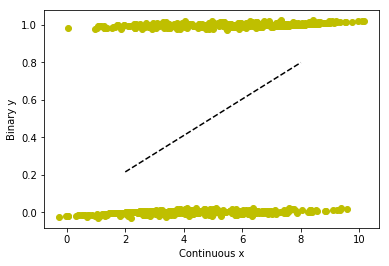

In [24]:
np.random.seed(seed=456613)

df = pd.DataFrame()
for probs in list(range(2, 9)):
    tmp = pd.DataFrame({
        'y': np.random.binomial(1, probs / 10, size=(1, 100))[0],
        'x': probs
    })
    print(probs/10) # Adding to make it simpler for meeee
    df = df.append(tmp)
    
x = df['x']

bin_y = df['y']

fit = np.polyfit(x,bin_y,1)

fit_fn = np.poly1d(fit)

jitter = np.random.randn(700)

plt.plot(x + jitter, bin_y + jitter / 100, 'yo', x, fit_fn(x), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Binary y')
plt.show()

While we _could_ fit a linear regression line to this data, you can see that it would be a very poor fit.  A well-fitting regression line will reflect the shape of the data, and this line cannot do that because the binary y only takes two possible values.  The relationship between x and y is very, very non-linear.  If we tried to do regression anyway, it would lead to a very badly fitting model.

Let's try another strategy and convert those binary values into the odds of getting $y=1$ for each value of $x$.

In [16]:
df.head()

,x,y
0,2,0
1,2,0
2,2,0
3,2,1
4,2,0


y1_ct: 19
y0_ct: 81
y1_ct: 33
y0_ct: 67
y1_ct: 42
y0_ct: 58
y1_ct: 56
y0_ct: 44
y1_ct: 54
y0_ct: 46
y1_ct: 70
y0_ct: 30
y1_ct: 81
y0_ct: 19
[0.2345679012345679, 0.4925373134328358, 0.7241379310344828, 1.2727272727272727, 1.173913043478261, 2.3333333333333335, 4.2631578947368425]


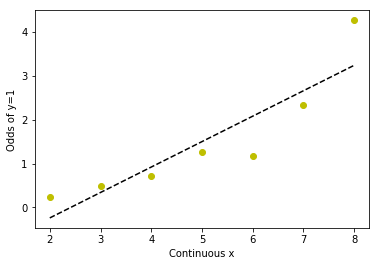

In [18]:
xvals = x.unique()

yodds = []
for xi in xvals:
    y1_ct = bin_y[x == xi].sum() # The number of trials y = 1.
    y0_ct = len(bin_y[x == xi]) - y1_ct  # The number of trials y = 0.
    yodds.append(y1_ct / y0_ct)  # Odds of getting y = 1 for xi.
    
    print('y1_ct: {}\ny0_ct: {}'.format(y1_ct, y0_ct))
print(yodds)
fit = np.polyfit(xvals, yodds, 1)
    
fit_fn = np.poly1d(fit)

plt.plot(xvals, yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Odds of y=1')
plt.show()

That's starting to look nicer.

To get the odds, we counted up how many times $y=1$ for each value of $x$ and divided it by the number of times $y=0$.  This gives us the odds of getting $y=1$ for each value of $x$.  The odds are a continuous variable, rather than a binary one. However, as we can see, the relationship between the odds and the continuous $x$ is still not linear – there is variation in the odds that isn't being captured by $x$.

To capture that nonlinearity, we can try a non-linear transformation of the odds variable.

## Linear vs non-linear transformations

A linear transformation is one where the relationship between the original value and the transformed value is the same for all values in a variable.  Addition, subtraction, multiplication, and division are examples of linear transformations:

|x|x+3|x+3-1|x*5|x*4/2|
|-|-|-|-|-|
|1|4|3|5|2|
|2|5|4|10|4|
|3|6|5|15|6|
|4|7|6|20|8|

For the addition example, the input is _always 3 less_ than the output. For the multiplication example, the output _is always 5 times larger_ than the input. 

Not every transformation is linear. Let's look at squaring and logarithms for example.

|x|x<sup>2</sup>|x<sup>2</sup>/x|log<sub>2</sub>(x)|log_x-x|
|-|-|-|-|-|
|1|1|1|0|-1|
|2|4|2|1|-1|
|3|9|3|1.58|-1.42|
|4|16|4|2|-2|

Here a one-unit change in the input ($x$) to the square and log transformations doesn't create same-sized changes in the output.  For the square transformation, the larger the input, the _bigger_ the impact of increasing or decreasing the input by 1.  For the logrithm transformation, the larger the input, the _smaller_ the impact of increasing or decreasing the input by 1 (except for log(1), which is a special case).

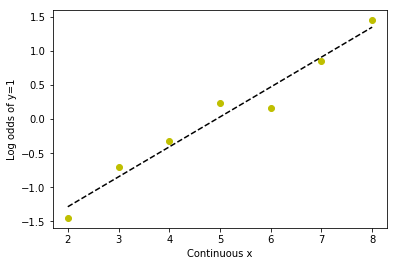

In [27]:
ln_yodds = np.log(yodds)

fit = np.polyfit(xvals, ln_yodds, 1)

fit_fn = np.poly1d(fit)

plt.plot(xvals, ln_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Log odds of y=1')

plt.show()

Now _that_ looks more like a linear relationship, with distances of similar magnitude between the points.  Regression can work with this.  The drawback, of course, is that working with logged odds leads to conclusions like "A 1-year increase in age leads to a 2.2 log-odds increase in the likelihood of having a hearing problem," which is basically gibberish to most people.  As a result, when interpreting individual coefficients from a binary logistic regression, it is customary to back-transform the log-odds into odds by exponentiating ($e^{logit(p)}$), and then interpret the odds.

Note that it is the convention to use the natural log when logging the odds, and therefore the exponentiation uses Euler's number $e$ as the base.

## Thinking Like a Data Scientist

The ability to clearly communicate results like this is a _key skill_ of the data scientist. Your data and models are worthless unless people understand them well enough to act. 

Imagine you ran a binary logistic regression predicting likelihood of developing a hearing problem, using age in years and male (0=female, 1=male) as predictors. Your final model looks like this: 

$$logit(HasHearingProblem) = -1 + .02 * age + 1 * male$$

Write out a description of the effects that age and gender have on the odds of developing hearing problems in terms a layperson could understand.  Include estimates for the odds of hearing problems in a 95 year old woman and a 50 year old man. Discuss your interpretation with your mentor.

log based e (has hearing problem) = -1 + .02 * age + 1 * male

50 year old man is loge(x) = 1. so the answer is the odds are e.
so 2.71828 more likely to have hearing problems than not. 2.72x + x = 1
73% chance of having a hearing problem for this gent.

95 year old woman

log based e (has hearing problem) = -1 + .02 * age + 1 * male

loge(x) = .9

e^.9 = x

2.45 times as likely to have hearing problem as not to have it.
71% chance of having hearing problem for this lady

In [29]:
2.71828**.9

2.4596016221445542